In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nose.tools import *

from sklearn.linear_model import LogisticRegression
# Write your imports here

# Regression Models Lab
## Logistic regression: problem statement, derivation, usage

### Classification: Problem Statement
In many real cases, the output variable is categorical, i.e. our model should return one of some predefined categories.

There are a lot of examples:
* Classifying images
* Classifying diseases (is a given patient healthy or ill?)
* Any case of "good / bad" classification
* Anomaly detection (e.g. credit card fraud detection)
* Processes which involve creating catalogs, etc.

We'll start with the simplest case:
* Only one input variable $x$
* Binary output variable $y$, i.e. either $y = 0$ or $y = 1$

### Problem 1. Generate Some Sample Data (1 point)
Let's imagine the simplest possible case. For example, we can think of $x$ as "hours of studying time" and $y$ as "passed exam" (0 of false, 1 if true).

A class has 20 students. 12 of them studied between 1 and 3 hours and didn't pass the exam. The other 8 studied between 7 and 10 hours and passed the exam. Let's model this situation.

First, to make our work easier, we can split it into two: for failed and passed students. Each student studied a random time, so let's choose this from a random uniform distribution (hint: `np.random.uniform(min, max, size)`).

Create the following:
```python
failed_student_times = np.random.uniform(?, ?, ?)
passed_student_times = np.random.uniform(?, ?, ?)
all_times = np.concatenate([failed_student_times, passed_student_times])
```

Now, let's generate the outcome variable: we need 12 zeros, followed by 8 ones.
```python
exam_result = ...
```

**Note:** We don't need to use `numpy` arrays but they will give us many benefits later. One is that our code will be really easy and short, and another is that they are very fast (in terms of computation time).

In [24]:
failed_student_times = np.random.uniform(1, 3, 12)
passed_student_times = np.random.uniform(7, 10, 8)
all_times = np.concatenate([failed_student_times, passed_student_times])

exam_result = []
for time in all_times:
    if time <= 3:
        exam_result.append(0)
    else:
        exam_result.append(1)
exam_result = np.array(exam_result)

In [25]:
assert_is_instance(all_times, np.ndarray)
assert_is_instance(exam_result, np.ndarray)

If we now plot the student performance, we'll get something like this:

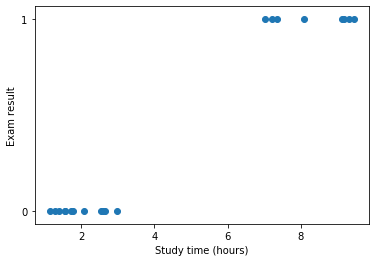

In [26]:
def plot_exam_results():
    plt.scatter(all_times, exam_result)
    plt.xlabel("Study time (hours)")
    plt.ylabel("Exam result")
    plt.yticks([0, 1])
    plt.show()
plot_exam_results()

There's a very obvious distinction between the two classes. Once again, that's because we wanted so.

How can we model the data? An example would be:
```python
if x < 5: # or x < 6, or something like that
    return 0
else:
    return 1
```

This model works but let's look at a more realistic scenario.

### Problem 2. Generate More Realistic Sample Data (1 point)
Now, this was a really simple view. A more involved model would include some error.

First, let's ensure the test results are repeatable, even with random variables:

In [9]:
np.random.seed(42)

Let's reuse the previous example but this time:
* Generate 20 study times between 1 and 10. Choose each number randomly from a uniform distribution (hint: this is the same as what you did before).
* Generate the exam output variable like this: For each study time, if it's $\le$ 3 hours, it should be 0, if it's $\ge$ 7 hours, it should be 1. If the study time is between 3 and 7 hours, decide randomly whether it should be 0 or 1.
* How do we decide randomly between 0 and 1? A simple way would be to generate a random number between 0 and 1: `np.random.random()`. If that number is >= 0.5, say the student passed the exam and vice versa.

In [29]:
all_times = None
exam_result = None

all_times = np.random.uniform(1, 10, 20)

exam_result = []
for time in all_times:
    if time <= 3:
        exam_result.append(0)
    elif time >= 7:
        exam_result.append(1)
    else:
        time = np.random.random()
        if time >= 0.5:
            exam_result.append(1)
        else:
            exam_result.append(0)
exam_result = np.array(exam_result)

In [30]:
assert_is_instance(all_times, np.ndarray)
assert_is_instance(exam_result, np.ndarray)

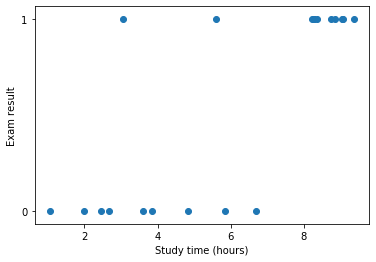

In [31]:
plot_exam_results()

Now the results look more fuzzy. It's obvious that we can't model them with 100% accuracy.

Still, let's try some things.

### Problem 3. Decide on a Modelling Function (2 points)
We can see that our old approach can work somewhat. If we try to plot the prediction function, we'll see this:

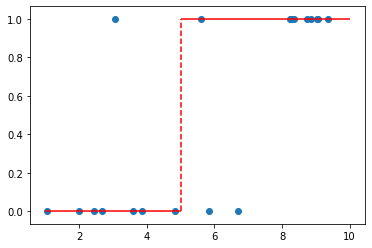

In [32]:
plt.scatter(all_times, exam_result)
plt.hlines([0, 1], [1, 5], [5, 10], color = "red")
plt.vlines(5, 0, 1, linestyle = "dashed", color = "red")
plt.show()

The red line is called "decision boundary". We can see that we misclassified some students but we are mostly correct.

However, the function has problems. First of all, it's undefined at $x = 5$ (we don't know if it's 0 or 1). Second, it has "sharp corners", and mathematicians hate functions with sharp corners :).

We're looking for a function that kind of looks like our line. And there is such a function. It's called a **sigmoid** function. Its definition is like this:

$$ \sigma(z) = \frac{1}{1+e^{-z}} $$

Implement the previous formula in code. Note: you can use `np.exp(something)` instead of `np.e ** something` - it's much more reliable.

In [33]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z)) 

Now that we have the function (and hopefully it's correct :D), we can plot it. The plot should look similar to what's described in [this](https://en.wikipedia.org/wiki/Sigmoid_function) article.

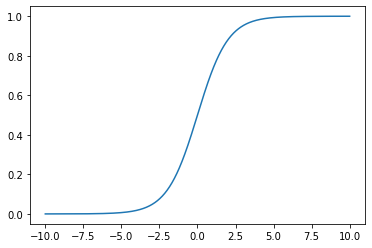

In [35]:
x = np.linspace(-10, 10, 1000)
y = sigmoid(x) # Note that this line should work correctly
plt.plot(x, y)
plt.show()

This function, as you can see, has interesting properties:
* For really large negative $x$ (say $x < -5$), it's practically 0
* For really large positive $x$, it's practically 1
* At 0, it's 0.5 exactly

Also, it looks like our original guess and has no sharp corners. This function is also called **logistic function** and it will be our **modelling function**.

In [36]:
assert_almost_equal(sigmoid(-50), 0, delta = 1e-10)
assert_almost_equal(sigmoid(0), 0.5, delta = 1e-10)
assert_almost_equal(sigmoid(50), 1, delta = 1e-10)

We will need to fix an issue: $\sigma(z)$ has continuous output, as we already saw. How do we make it binary?

Simple enough; if $\sigma \lt 0.5$, we'll output 0 and 1 otherwise (note that this will assign class 1 to $\sigma(0)$ but that's OK).

Let's write a function that accepts a $z$ (number between 0 and 1) and decides what output label should it produce: 0 or 1. Note that this is exactly the process that we defined as "thresholding" some time ago.

In [37]:
def generate_output(z):
    sigmoid_result = sigmoid(z)
    if sigmoid_result < 0.5:
        return 0
    else:
        return 1

In [38]:
for x in np.arange(-2, 3):
    print(x, sigmoid(x), generate_output(x))

-2 0.11920292202211755 0
-1 0.2689414213699951 0
0 0.5 1
1 0.7310585786300049 1
2 0.8807970779778823 1


### Problem 4. Use the Sigmoid Function as a Model (1 point)
Now, we've got another issue ahead. How can we model the parameter $z$ of $\sigma(z)$? All we know is that it should be a number.

Well, this number must be somehow related to the input parameters. The simplest possible relation is linear:

$$z = ax + b$$

where $x$ is the number of hours, $a$ is its coefficient, and $b$ is an intercept (also called "free term" or "bias term").

Therefore, we can rewrite our function $\sigma(z)$ to be $l(x)$, like so:
$$ l(x) = \frac{1}{1+e^{-(ax+b)}}=\sigma(ax+b) $$

$l$ stands for "logistic function".

This function has two properties:
* Its value will tell us which class to choose (0 or 1)
* It can serve as a probability: $l(x)$ is equal to the probability that the output class is 1

Write a function that does exactly this. **Reuse your implementation** of the `sigmoid` function.

In [39]:
def logistic_function(x, a, b):
    z = a * x + b
    return 1 / (1 + np.exp(-z)) 

In [40]:
# The function should work with both numbers and numpy arrays
print(logistic_function(0, 1, 0)) # Should be 0.5
print(logistic_function(np.arange(-2, 5), a = -2, b = 3)) # Should return decreasing numbers

0.5
[0.99908895 0.99330715 0.95257413 0.73105858 0.26894142 0.04742587
 0.00669285]


Now the problem is similar to what we did before: we need to find the best parameters $a$ and $b$.

Let's try out different values of $a$ and $b$, just to get a feel of what we need to do:

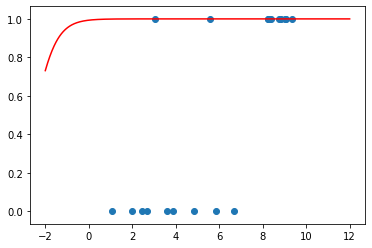

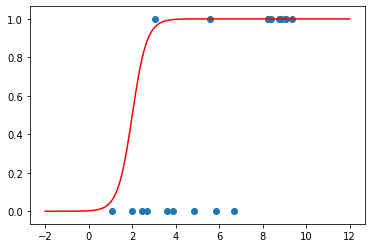

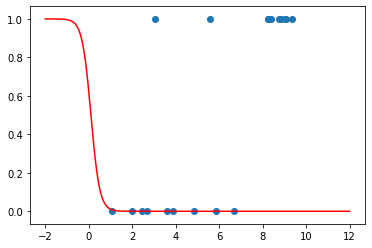

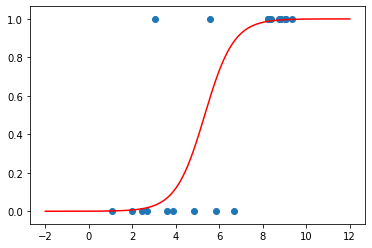

In [41]:
def plot_prediction_with_sigmoid(a, b, x, y, title = ""):
    plt.scatter(x, y)
    logistic_x_values = np.linspace(-2, 12, 1000)
    logistic_y_values = logistic_function(logistic_x_values, a, b)
    plt.plot(logistic_x_values, logistic_y_values, color = "red")
    plt.title(title)
    plt.show()

for a, b in [[2, 5], [3, -6], [-5, 0.5], [1.5, -8]]:
    plot_prediction_with_sigmoid(a, b, all_times, exam_result)

We can understand that $a$ controls how "spread out" the function is, also if $a < 0$, the function is inverted. $b$ seems to control where the "center point" is.

### Problem 5. Choose an Error Function (2 points)
Now that we have an idea what our modelling function does, the next step is to choose a good error function.

The error function should accept a single predicted value $\tilde{y} = \sigma(ax+b)$ and an actual value $y$. It should tell us whether we're right or not. Note that the sigmoid value is always between 0 and 1.

**Note:** In terminology, there's a difference between "error function" and "cost / loss function". The error function is defined for one point only while the cost function is for the entire dataset.

Since we have two classes, we will need to define a separate error function for each class: $error_0$ will correspond to the case where the correct class should be $0$; $error_1$ will correspond to class $1$.

Our intuition is that the errors should be equal to zero if we predicted the class correctly, and greater than zero otherwise. So, for example, the error functions might look like this:

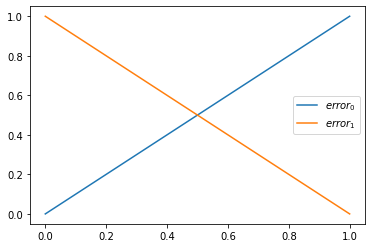

In [42]:
sigmoid_values = np.linspace(0, 1, 1000)
error_0_values = sigmoid_values
error_1_values = - sigmoid_values + 1
plt.plot(sigmoid_values, error_0_values, label = "$error_0$")
plt.plot(sigmoid_values, error_1_values, label = "$error_1$")
plt.legend()
plt.show()

Take $error_0$ for example. It is 0 if the predicted class is 0 and increases everywhere else.

There are many choices for error functions. However, not all are created equal. For purposes we're not going to discuss, it turns out the best error function for logistic regression is this:
$$
error_0 = -\ln(1-x) \\
error_1 = -\ln(x)
$$

If you're interested why this function is the best, you can look it up online. The main idea is that this function has only one minimum. When we do gradient descent, we can get stuck in a local minimum and miss the global one. This error function ensures that nasty thing won't happen.

Let's implement and inspect the two functions:

In [43]:
def error_0(x):
    return -np.log(1 - x)

def error_1(x):
    return -np.log(x)

In [44]:
assert_almost_equal(error_0(0), 0)
assert_greater(error_0(1), 0)

assert_almost_equal(error_1(1), 0)
assert_greater(error_1(0), 0)


C:\Users\Denis\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\Denis\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


C:\Users\Denis\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\Denis\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


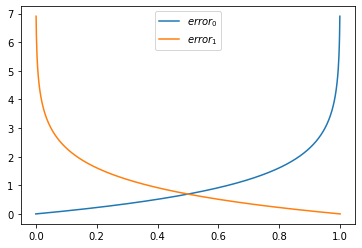

In [45]:
# This will produce errors because log(0) is infinity; we can just ignore them for now
sigmoid_values = np.linspace(0, 1, 1000)
plt.plot(sigmoid_values, error_0(sigmoid_values), label = "$error_0$")
plt.plot(sigmoid_values, error_1(sigmoid_values), label = "$error_1$")
plt.legend()
plt.show()

These error functions not only work. They have an **additional property** that makes them special. Focus on $error_0$ for  example. Besides being $0$ when the predicted class is $0$, it's also equal to $\infty$ when we get the class totally wrong.

That's how you punish an algorithm for being wrong :)!

One more question: how do we decide whether we should use $error_0$ or $error_1$? We look at the original $y$ (`exam_result` in our case). If $y = 0$, we'll use $error_0$ and vice versa. This will combine our two error functions into one convenient error function.

Write this convenient function. It should accept an input value $z \in (-\infty; \infty)$ and an expected output value $y$ (0 or 1).

First, it should pass $z$ through the sigmoid function to get $\sigma(z)$. After that, based on $y$, it should choose the correct function and return the error.
* If $y = 0$, return $error_0(\sigma(z))$
* If $y = 1$, return $error_1(\sigma(z))$

In [46]:
def get_error(z, y):
    sigmoid_result = sigmoid(z)
    if y == 0:
        return error_0(sigmoid_result)
    else:
        return error_1(sigmoid_result)

Let's test this function to see that it works. If we pass a negative value for $z$, the sigmoid function will be approximately zero, so it predicts class 0. If $y = 0$, congrats, we have almost zero error. If $y = 1$, we'll get punished.

In [47]:
print(get_error(-10, 0)) # Almost zero
print(get_error(-10, 1)) # Very large (approximately equal to 10)

4.539889921682063e-05
10.000045398899218


### Problem 6. Calculate the Cost Function from the Error Function (1 point)
Now, we have an error function which accepts a real number $z$ and an expected class and returns the prediction error. Now we have to repeat what we did in step 4 and rewrite the entire thing to use $x$, the input value.

That's really simple. We should just take $x, y$, and the parameters $a, b$. All four parameters are real numbers. From them, we need to calculate $z = ax+b$. This $z$ is what we need to pass to `get_error(z, y)`.

Write a function that does this.

In [48]:
def compute_error_function(a, b, x, y):
    z = a * x + b
    return get_error(z, y)
    
print(compute_error_function(-5, 0, 1, 0)) # Should be about 0.007

0.006715348489118056


The total cost function is the sum of all errors. Write a function that accepts `data_x` and `data_y` - arrays of points, and also `a` and `b`. For each point, compute the error function. Sum all error functions to get the total cost.

In [49]:
def compute_total_cost(a, b, data_x, data_y):
    z = a * data_x + b
    zipped = zip(z, data_y)
    total_cost = 0
    for predicted, expected in zipped:
        total_cost += get_error(predicted, expected)
    return total_cost

Now let's go back and see what total costs we should get. We saw that the last function approximation looked most reasonable. It should have the smallest error.

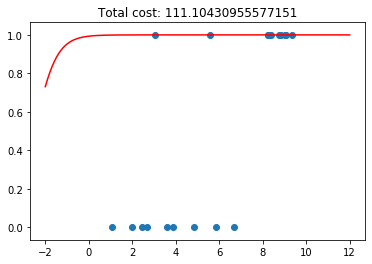

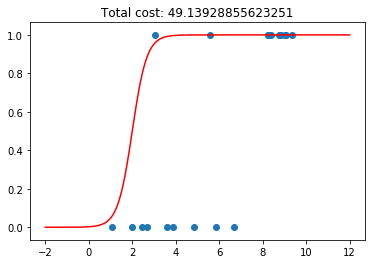

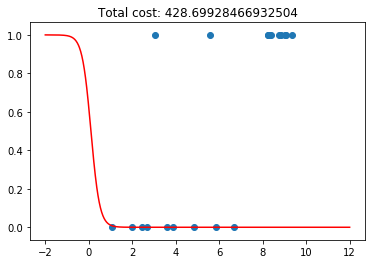

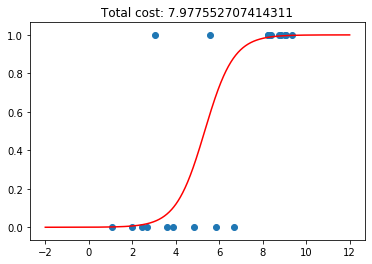

In [50]:
for a, b in [[2, 5], [3, -6], [-5, 0.5], [1.5, -8]]:
    total_cost = compute_total_cost(a, b, all_times, exam_result)
    plot_prediction_with_sigmoid(a, b, all_times, exam_result, "Total cost: " + str(total_cost))
    

### Problem 7. Perform gradient ascent (1 point)
Now we've gone really far. What remains is to try to find the unknown coefficients $a$ and $b$.

We're not going to cover the details of the derivation of the gradients. If you're interested how this works, you can look it up online. The method is fairly common in statistics and is called "maximum likelihood estimation", i.e. we try to estimate the parameters $a$ and $b$ so that the prediction $\tilde{y}$ is as close as possible to the observed variable $y$.

Here's an important detail, though. Because of how these calculations go, we need to **maximize**, not minimize the target function. The method is called **gradient ascent**. When we update the values, we add, not subtract, the new gradients.

$$
a = a + \nabla J_a \\
b = b + \nabla J_b
$$

The implementation of `perform_gradient_ascent()` for logistic regression is given to you.

In [51]:
def perform_gradient_ascent(a, b, data_x, data_y, learning_rate):
    y_predicted = sigmoid(a * data_x + b)
    errors = data_y - y_predicted
    a_gradient = np.sum(data_x * errors)
    b_gradient = np.sum(errors)
    new_a = a + learning_rate * a_gradient
    new_b = b + learning_rate * b_gradient
    return new_a, new_b

Use that to perform 3 000 iterations. Start from $a = 0,\ b = 0$. At each iteration, update $a$ and $b$. Print the final values at the end. Use `all_times` and `exam_result` as your variables. Use a learning rate $\alpha = 0.01$.

If you wish, you can call `compute_total_cost(a, b, data_x, data_y)` and even plot the learning curve. This will give you a good idea whether your model worked or not.

In [52]:
def train_model(data_x, data_y):
    a = 0
    b = 0
    learning_rate = 0.01
    for step in range(3001):
        a, b = perform_gradient_ascent(a, b, data_x, data_y, learning_rate)
    return a, b

In [53]:
a, b = train_model(all_times, exam_result)
print("a = {}; b = {}".format(a, b))

a = 0.8803773292603919; b = -5.0017543629290735


In [54]:
assert_is_not_none(a)
assert_is_not_none(b)

We can compare our implementation to something else. An algorithm that we know works for sure, is the `scikit-learn` implementation.

The next cell performs logistic regression using `scikit-learn`. You should observe that the parameters are almost the same as those we got. This means that our implementation works well.

The `C` parameter is related to something we haven't discussed called **regularization**. A large number means no regularization is applied, which is what we did. A more detailed discussion is out of the scope of this lab.

In [55]:
model = LogisticRegression(C = 1e9)
model.fit(all_times.reshape(-1, 1), exam_result)
print("a = {}; b = {}".format(model.coef_[0, 0], model.intercept_[0]))

a = 0.8808915330758015; b = -5.005176392752407


### Problem 8. Test your model (1 point)
Let's create a `predict()` function. It should accept `a` and `b`, and the training data (`all_times` in our case). Its job is to predict the output class. To do this, it should use the already defined `generate_output()` function. To make things easier, this function is provided for you.

In [56]:
def predict(a, b, x_data):
    return generate_output(a * x_data + b)

Let's now call `predict()` for every input value and compare our outputs to the original ones.

In [57]:
exam_result_predicted = np.array([predict(a, b, time) for time in all_times])
print("Predicted:", exam_result_predicted)
print("Actual:   ", exam_result)

Predicted: [0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0]
Actual:    [0 0 1 1 0 1 1 0 1 0 1 1 0 0 1 0 1 1 0 1]


A metric for how good our classification is, is called **accuracy**. It's the ratio of guessed classes to all classes.

$$A = \frac{\text{number of correct guesses}}{\text{number of total results}}$$

Write a function called `calculate_accuracy` which accepts the predicted exam results and the actual exam results and returns the accuracy score.

In [58]:
def calculate_accuracy(predicted, actual):
    correct = np.sum(predicted == actual)
    return correct / len(actual)

In [59]:
print(calculate_accuracy(exam_result_predicted, exam_result))

0.8


Finally, if we want to play a little, we can plot correct and incorrect results. This is left as an exercise to the reader :).

### Additional notes: OOP
We're not looking at object-oriented programming in this course, but we can wrap everything we did in a class. I am including this just for fun. The class contains only vary basic input checks. A real-life scenario will include much more validation.

Also, in this class, I'm calling the functions `train_model()`, `predict()`, and `calculate_accuracy()` directly because I know they're already written. A real class won't simply reuse them, they will be part of the class.

In [60]:
class OneVariableLogisticRegression(object):
    def __init__(self):
        self.is_trained = False
        
    def train(self, x, y):
        assert_is_instance(x, np.ndarray)
        assert_is_instance(y, np.ndarray)
        assert_equal(x.ndim, 1)
        assert_equal(y.ndim, 1)
        
        self.is_trained = True
        self.a, self.b = train_model(x, y)
    
    def predict(self, x):
        if not self.is_trained:
            raise RuntimeError("The model is not trained")
        return np.vectorize(predict)(self.a, self.b, x)
    
    def score(self, y_predicted, y_actual):
        return calculate_accuracy(y_predicted, y_actual)
    
# Usage
model = OneVariableLogisticRegression()
model.train(all_times, exam_result)
print("a = {}; b = {}".format(model.a, model.b))
print("Predicted:", model.predict(all_times))
print("Accuracy: {0:.3f}".format(model.score(model.predict(all_times), exam_result)))

a = 0.8803773292603919; b = -5.0017543629290735
Predicted: [0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0]
Accuracy: 0.800
